### Imports and Options

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 1
import duckdb
import pandas as pd
from IPython.display import Markdown, display
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import functions.display_functions as disf
import functions.data_format_functions as dff
from functions.project_functions_classes import Team, MatchPlayers
from mplsoccer import Pitch
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# import cvxopt
%aimport functions.display_functions, functions.data_format_functions, functions.project_functions_classes

#### Options

In [2]:
pd.set_option('mode.chained_assignment', None)
sns.set()
base_fig_width = 8
base_fig_height = 4.5
alpha=0.95
significance=1-alpha

In [3]:
con = duckdb.connect()
con.execute(f"INSTALL sqlite")
con.execute(f"LOAD sqlite")
con.execute(f"SET GLOBAL sqlite_all_varchar=true")
con.execute(f"CALL sqlite_attach('data/database.sqlite')")

In [4]:
tables=con.query(
            f"""--sql
SELECT table_name as 'Table Name', COUNT(column_name) AS 'Column Count' FROM information_schema.columns GROUP BY table_name
"""
        ).to_df()

In [5]:
table_columns = con.query(
    f"""--sql
SELECT table_name,
    GROUP_CONCAT(column_name) AS column_names
FROM information_schema.columns
GROUP BY table_name"""
).to_df()
tables['column_names']=table_columns['column_names'].apply(lambda x: x.split(','))

In [6]:
row_counts={}
for table_name in tables['Table Name']:
    row_counts[table_name]=con.query(f"""--sql
                                     SELECT COUNT(*) FROM {table_name}
                                     """).fetchone()[0]
    

tables=tables.join(pd.Series(row_counts).rename('Row Count'), on='Table Name')

### Match

#### Preparing Match data

In [7]:
match_cols = tables.loc[tables["Table Name"] == "Match", "column_names"].to_list()[0]
match_cols_to_remove = ["league_id","stage","match_api_id","cross"]
match_cols = [col for col in match_cols if col not in match_cols_to_remove]
match_raw = con.query(f"""--sql
          SELECT {', '.join(match_cols)} FROM Match
          """).to_df()
match_raw.set_index('id',inplace=True)

#### What countries were the matches played in?

##### Fetching country ids:

In [8]:
country=con.query("""--sql
SELECT * FROM Country""").to_df().set_index('id')
country=country.to_dict()['name']

##### Plotting:

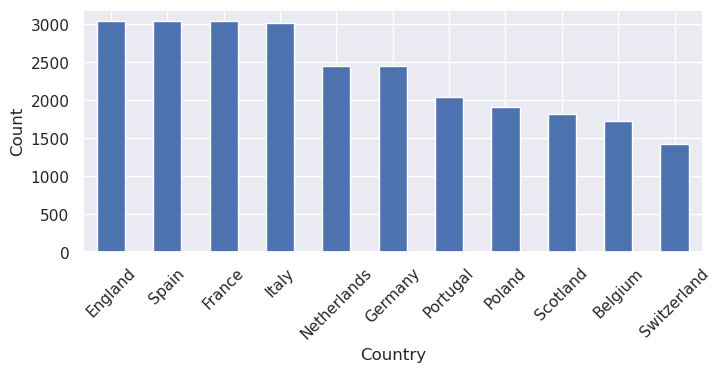

In [9]:
fig_match_country, ax_match_country = plt.subplots(
    figsize=(base_fig_width, 0.7*base_fig_height)
)
match_raw.value_counts("country_id").rename(country).plot.bar(ax=ax_match_country)
ax_match_country.set_xlabel('Country')
ax_match_country.set_ylabel('Count')
ax_match_country.tick_params(axis='x', rotation=45)
plt.show()

#### Whats the match distribution by date and season?

##### Preparing the season and date data:

In [10]:
match_raw["date"] = pd.to_datetime(match_raw["date"])
match_date_count = match_raw.resample("D",on='date').count().cumsum()

seasons=match_raw.groupby('season').agg(start=('date', 'min'),end=('date','max'),count=('season','count'))
seasons['length']=seasons['end']-seasons['start']


##### Plot:

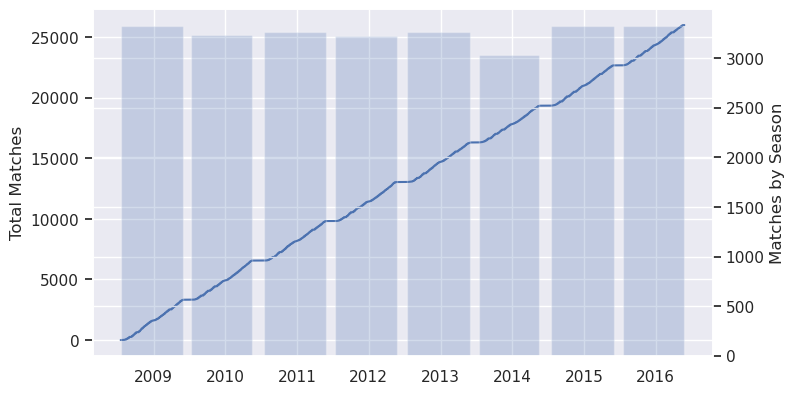

In [11]:
fig_match_count_date, ax_match_count_date = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)

ax_match_count_date.plot(match_date_count.index, match_date_count["country_id"])
ax_match_count_date_season = ax_match_count_date.twinx()
ax_match_count_date_season.bar(
    x=seasons["start"],
    height=seasons["count"],
    width=seasons["length"],
    align="edge",
    alpha=0.25,
)
ax_match_count_date.set_ylabel("Total Matches")
ax_match_count_date_season.set_ylabel("Matches by Season")

plt.show()

#### What is the distribution of goal difference between home and away teams?

##### Calculating the goal difference for each mach:

In [12]:
match_raw[["home_team_goal", "away_team_goal"]] = match_raw[
    ["home_team_goal", "away_team_goal"]
].astype(int)
match_raw["outcome"] = match_raw["home_team_goal"] - match_raw["away_team_goal"]
match_outcomes = match_raw["outcome"].value_counts().to_frame("count")
match_outcomes.reset_index(names=["value"], inplace=True)
match_outcomes["outcome"] = match_outcomes["value"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)
match_outcomes["color"] = match_outcomes["value"].apply(
    lambda x: sns.color_palette()[0]
    if x > 0
    else (sns.color_palette()[3] if x < 0 else sns.color_palette()[4])
)

##### Plot:

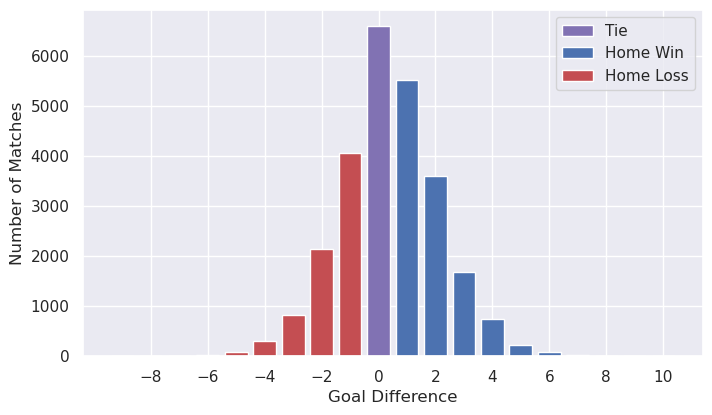

In [13]:
fig_match_outcomes,ax_match_outcomes=plt.subplots(figsize=(base_fig_width,base_fig_height))
ax_match_outcomes.bar(match_outcomes['value'],match_outcomes['count'],label=match_outcomes['outcome'],color=match_outcomes['color'],align='center')
handles, labels = ax_match_outcomes.get_legend_handles_labels()
ax_match_outcomes.legend(handles[:3],labels[:3])
ax_match_outcomes.set(xticks=np.arange(start=-8,stop=12,step=2))
ax_match_outcomes.set_ylabel('Number of Matches')
ax_match_outcomes.set_xlabel('Goal Difference')
plt.show()

#### Is there a home advantage?

##### Chi square test of non-tie matches with the null hypothesis being that there is an equal amount of home wins and away wins:

In [14]:
total_home_wins = match_outcomes.loc[match_outcomes['outcome'] == 'Home Win', 'count'].sum()
total_away_wins = match_outcomes.loc[match_outcomes['outcome'] == 'Home Loss', 'count'].sum()
home_advantage_result=stats.chisquare([total_home_wins,total_away_wins])

##### Results:

In [15]:
Markdown(f"""
Based on a chi-square test with a confidence level of 95%, the p-value of {home_advantage_result.pvalue:.2e}
strongly suggests that there is a significant home advantage.
{total_home_wins} of all non-tie wins were by the home team,
while only {total_away_wins} matches were won by away teams.
""")


Based on a chi-square test with a confidence level of 95%, the p-value of 2.82e-224
strongly suggests that there is a significant home advantage.
11917 of all non-tie wins were by the home team,
while only 7466 matches were won by away teams.


#### What are the different player combinations used?

##### Preparing player position combination columns:

In [16]:
# Getting lists of position column names
home_x_cols=[x for x in match_raw.columns.to_list() if 'home_player_X' in x]
home_y_cols=[x for x in match_raw.columns.to_list() if 'home_player_Y' in x]
away_x_cols=[x for x in match_raw.columns.to_list() if 'away_player_X' in x]
away_y_cols=[x for x in match_raw.columns.to_list() if 'away_player_Y' in x]

# Changing  the data type to numeric
match_raw[home_x_cols + home_y_cols + away_x_cols + away_y_cols] = match_raw[
    home_x_cols + home_y_cols + away_x_cols + away_y_cols
].apply(pd.to_numeric)

# Putting the home player coordinates into frozensets of (x,y) tuples
match_raw["combinations_home"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[home_x_cols], row[home_y_cols])]),
    axis=1,
)

# Changing any values that contain at least a single NaN value to Nan
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[away_x_cols], row[away_y_cols])]),
    axis=1,
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

##### Number of different 11 player combinations:

In [17]:
unique_combos = pd.concat(
    [match_raw["combinations_home"], match_raw["combinations_away"]]
).value_counts().to_frame(name='count').reset_index(names=['combo'])
len(unique_combos)


37

##### Combination distribution on the pitch:

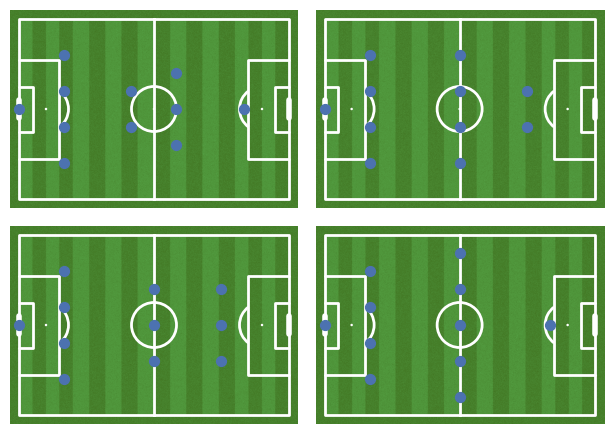

In [18]:
# Correcting the position of the goal keeper
unique_combos["scaled_combo"] = unique_combos["combo"].apply(
    lambda x: frozenset((5, 1) if t == (1, 1) else t for t in x)
)

# Scaling to the pitch plot
pitch_y_offset = 4 - dff.scale_num(1, 1, 11, -4, 80)
unique_combos["scaled_combo"] = unique_combos["scaled_combo"].apply(
    lambda x: frozenset(
        (
            dff.scale_num(t[0], 1, 11, 0, 80) + pitch_y_offset,
            dff.scale_num(t[1], 1, 11, 0, 100),
        )
        for t in x
    )
)

pitch = Pitch(
    pitch_color="grass", line_color="white", stripe=True,
    )

fig_pitch, ax_pitch = pitch.draw(nrows=2, ncols=2, figsize=(base_fig_width, base_fig_height))
ax_pitch=ax_pitch.flatten()

for i, combo in enumerate(unique_combos[:4].iterrows()):
    for pos in combo[1]["scaled_combo"]:
        ax_pitch[i].scatter(
            pos[1],
            pos[0],
            s=50,
            color=sns.color_palette("deep")[0],
        )
plt.tight_layout(w_pad=-6)
plt.show()

### Player attributes

#### What is the player rating and potential distribution?

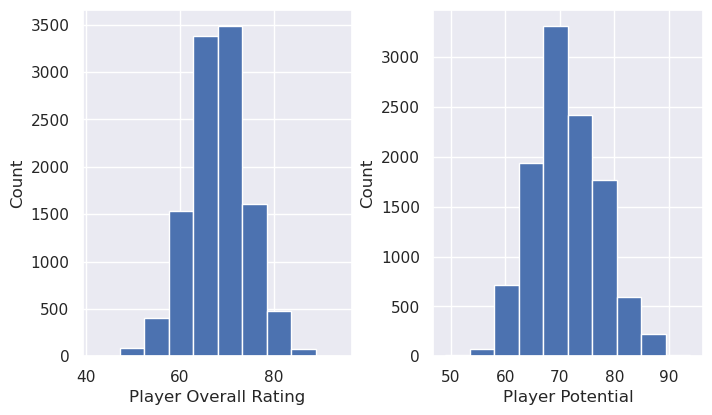

In [19]:
# Latest date

rating_potential = con.query(
    """--sql
SELECT overall_rating,
    potential
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date """
).to_df()
rating_potential.dropna(inplace=True)
rating_potential = rating_potential.astype(int)

fig_player_rating_hist, (
    ax_player_rating_hist,
    ax_player_potential_hist,
) = plt.subplots(1, 2, figsize=(base_fig_width, base_fig_height))

rating_potential.hist('potential',ax=ax_player_potential_hist)
rating_potential.hist('overall_rating',ax=ax_player_rating_hist)
disf.axis_titles(ax_player_potential_hist,xtitle='Player Potential',ytitle='Count')
disf.axis_titles(ax_player_rating_hist,xtitle='Player Overall Rating',ytitle='Count')
plt.show()

#### Whats is the foot preference distribution?

In [20]:
con.query(
f"""--sql
SELECT 
    COUNT(*) AS total,
    SUM(CASE WHEN preferred_foot = 'right' THEN 1 ELSE 0 END) AS right_count,
    SUM(CASE WHEN preferred_foot = 'left' THEN 1 ELSE 0 END) AS left_count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df().astype(int)

,total,right_count,left_count
0,11064,8373,2687


#### Do right and left footed players have a different overall rating?

##### Fetching the data:

In [21]:
player_f_rating=con.query(
f"""--sql
SELECT  CAST(overall_rating as INT) AS 'Overall Rating', preferred_foot
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

##### T-test:

In [22]:
player_f_rating_levresults = stats.levene(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
)

player_f_rating_tresults = stats.ttest_ind(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
    equal_var=player_f_rating_levresults.pvalue > significance,
)
Markdown(
    f"""t-statistic: {round(player_f_rating_tresults.statistic,2)}<br>
         p-val: {round(player_f_rating_tresults.pvalue,2)}<br>
         There {'is a' if player_f_rating_tresults.pvalue < significance else 'is no'} 
         significant difference in overall rating between right and left footed players
         """
)

t-statistic: -0.54<br>
         p-val: 0.59<br>
         There is no 
         significant difference in overall rating between right and left footed players
         

#### What is the distribution of goal keeper statistics?

##### Getting the histogram data for goal keeper diving ability:

In [23]:
goaly_hist_df=con.query(
f"""--sql
WITH bin_stats AS (
    SELECT (
            (
                MAX(CAST(gk_diving AS INT)) - MIN(CAST(gk_diving AS INT))
            ) / 10
        ) AS bin_size
    FROM Player_Attributes p
        JOIN(
            SELECT player_api_id,
                MAX(date) AS max_date
            FROM Player_attributes
            GROUP BY player_api_id
        ) sub ON p.player_api_id = sub.player_api_id
        AND p.date = sub.max_date
)
SELECT FLOOR(
        CAST(gk_diving AS INT) / (
            SELECT bin_size
            FROM bin_stats
        )
    ) * (
        SELECT bin_size
        FROM bin_stats
    ) AS bin,
    COUNT(*) AS count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date
GROUP BY bin
ORDER BY bin;
    """
).to_df().astype(int,errors='ignore')

##### Plotting the frequencies:

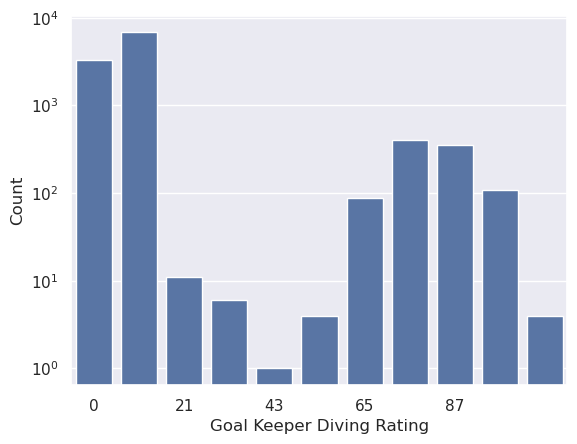

In [24]:
fig_goaly_stats, ax_goaly_stats = plt.subplots()
sns.barplot(goaly_hist_df, x="bin", y="count", ax=ax_goaly_stats, color=sns.color_palette()[0])
ax_goaly_stats.set_xticks(np.arange(0, 10, step=2))
ax_goaly_stats.set_xticklabels(
    np.linspace(goaly_hist_df["bin"].min(), goaly_hist_df["bin"].max(), num=5).astype(
        int
    )
)
ax_goaly_stats.set_yscale('log')
disf.axis_titles(ax=ax_goaly_stats, ytitle='Count', xtitle='Goal Keeper Diving Rating')
plt.show()

#### Is there a linear correlation between player overall ratings and their other attributes?

##### Importing all player attributes:

In [25]:
player_attr_raw=con.query(f"""--sql
SELECT * FROM Player_Attributes
""").to_df()
player_attr_numeric=['overall_rating',
'potential',
'crossing',
'finishing',
'heading_accuracy',
'short_passing',
'volleys',
'dribbling',
'curve',
'free_kick_accuracy',
'long_passing',
'ball_control',
'acceleration',
'sprint_speed',
'agility',
'reactions',
'balance',
'shot_power',
'jumping',
'stamina',
'strength',
'long_shots',
'aggression',
'interceptions',
'positioning',
'vision',
'penalties',
'marking',
'standing_tackle',
'sliding_tackle',
'gk_diving',
'gk_handling',
'gk_kicking',
'gk_positioning',
'gk_reflexes',
]
player_attr_raw[player_attr_numeric]=player_attr_raw[player_attr_numeric].apply(pd.to_numeric)
player_attr_raw['date']=pd.to_datetime(player_attr_raw['date'])

##### Calculating and displaying the correlations:

In [26]:
player_att_corrs = (
    player_attr_raw[player_attr_numeric]
    .corr()["overall_rating"]
    .to_frame()
    .join(
        player_attr_raw[player_attr_numeric]
        .loc[player_attr_raw[player_attr_numeric]["gk_diving"] > 50]
        .corr()["overall_rating"]
        .to_frame(),
        rsuffix='_goal_keeper'
    )
)


player_att_corrs.style.background_gradient('coolwarm')

,overall_rating,overall_rating_goal_keeper
overall_rating,1.000000,1.000000
potential,0.766757,0.803987
crossing,0.357699,-0.028771
finishing,0.329298,-0.028309
heading_accuracy,0.314099,-0.039555
short_passing,0.458361,0.120210
volleys,0.361470,-0.007451
dribbling,0.354324,-0.032803
curve,0.357772,-0.027312
free_kick_accuracy,0.349592,0.010384


#### Whats the distribution of attacking and defensive work?

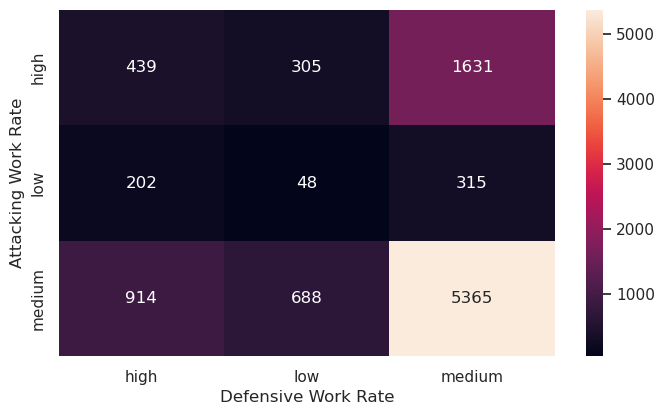

In [27]:
att_def_df = con.query(
    f"""--sql
SELECT attacking_work_rate, defensive_work_rate
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

fig_att_def, ax_att_def = plt.subplots(figsize=(base_fig_width, base_fig_height))
sns.heatmap(
    pd.crosstab(att_def_df["attacking_work_rate"], att_def_df["defensive_work_rate"])[
        ["high", "low", "medium"]
    ].loc[["high", "low", "medium"]],
    annot=True,
    fmt='.0f',
    ax=ax_att_def
)
disf.axis_titles(ax=ax_att_def,xtitle='Defensive Work Rate',ytitle='Attacking Work Rate')

### Teams

##### Getting the team attributes:

In [28]:
team_attr_raw = con.query(
f"""--sql
SELECT *
FROM Team_Attributes
"""
).to_df()

#### What is the distribution of Team attributes?

##### Making a list of numeric attributes and fixing data types:

In [29]:
team_numeric_cols = [
    "buildUpPlaySpeed",
    "buildUpPlayDribbling",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
]
team_categoric_cols = [col + "Class" for col in team_numeric_cols]
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)
team_attr_raw['date']=pd.to_datetime(team_attr_raw['date'])
team_attr_raw.set_index('id',inplace=True)

latest_team_attr=team_attr_raw.loc[team_attr_raw.groupby('team_api_id').date.idxmax()]

##### Plotting numeric attributes and their categories:

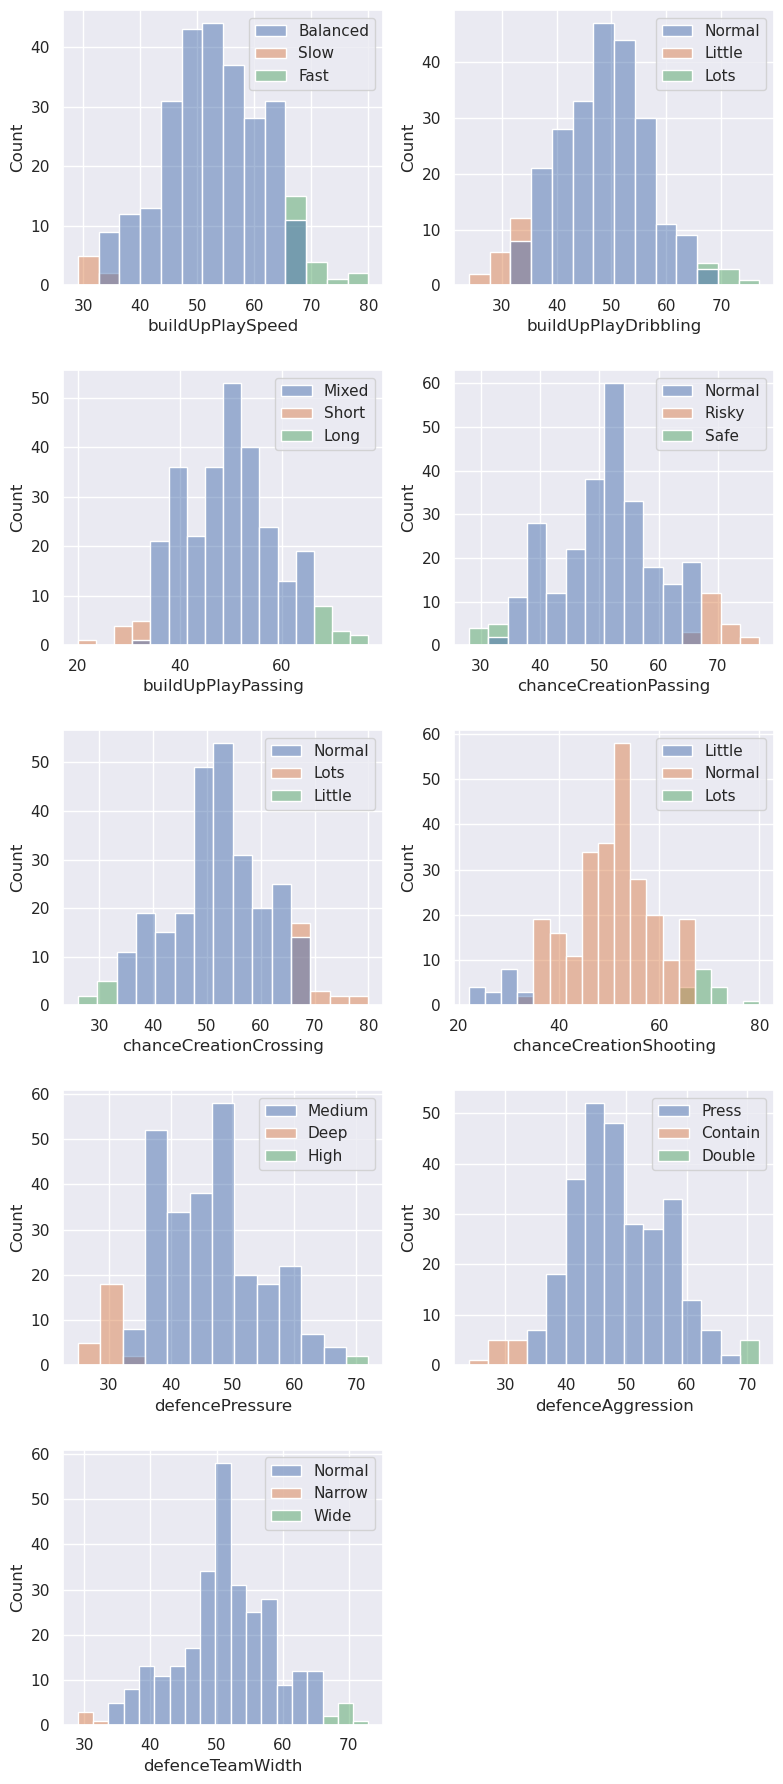

In [30]:
fig_team_attr,ax_team_attr=plt.subplots(5,2,figsize=(base_fig_width,base_fig_height*4))
ax_team_attr=ax_team_attr.flatten()
for i, attr in enumerate(team_numeric_cols):
    sns.histplot(latest_team_attr,x=attr, hue=attr+'Class',ax=ax_team_attr[i])
    ax_team_attr[i].get_legend().set_title("")

fig_team_attr.delaxes(ax_team_attr[-1])
plt.tight_layout(h_pad=2)
plt.show()

##### Plotting non numeric attributes:

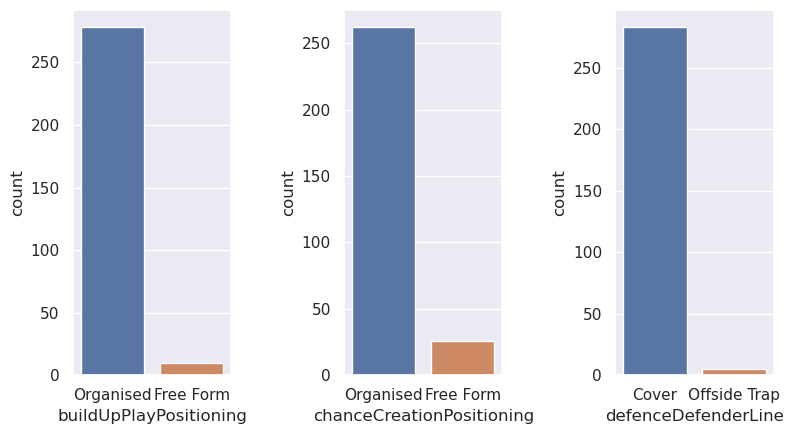

In [31]:
team_attr_non_numeric = [
    "buildUpPlayPositioningClass",
    "chanceCreationPositioningClass",
    "defenceDefenderLineClass",
]

fig_team_attr_cat, ax_team_attr_cat = plt.subplots(
    1, 3, figsize=(base_fig_width, base_fig_height)
)
ax_team_attr_cat = ax_team_attr_cat.flatten()

for i, attr in enumerate(team_attr_non_numeric):
    sns.countplot(data=latest_team_attr, x=attr, ax=ax_team_attr_cat[i])
    ax_team_attr_cat[i].set_xlabel(attr[:-5])
plt.tight_layout(w_pad=3)
plt.show()

#### Do the numeric team attributes correlate linearly with each other?

In [32]:
disf.get_correlation_pairs(latest_team_attr,0.3,-0.3)

,r-value,feature_pair
0,0.327754,"(buildUpPlaySpeed, chanceCreationPassing)"
2,0.466181,"(defenceAggression, defencePressure)"
3,0.363279,"(defenceTeamWidth, defencePressure)"


Certain defensive attribute seem to have a moderate linear correlation with each other, as well as build up play speed and chance creation passing attributes.

## Feature selection

### Starting line-up combinations

Making a copy the match DataFrame with only relevant information:

In [33]:
match_win_df = match_raw[
    [
        "country_id",
        "date",
        "home_team_api_id",
        "away_team_api_id",
        "home_team_goal",
        "away_team_goal",
    ]
]

match_win_df["home_team_win"] = match_win_df.apply(
    lambda x: 1 if x["home_team_goal"] > x["away_team_goal"] else 0, axis=1
)

In [34]:
match_win_df["home_team_win"].value_counts()

0    14062
1    11917
Name: home_team_win, dtype: int64

#### Do combinations influence the match outcome?

##### Adding the combination data:

In [35]:
# Number labels for unique combinations
combo_dict = unique_combos["combo"].to_dict()
combo_dict = {v: k for k, v in combo_dict.items()}

# Adding the combinations from the raw data
match_win_df_combo = pd.merge(
    match_win_df,
    match_raw[["combinations_home", "combinations_away"]],
    left_index=True,
    right_index=True,
)

# Changing the combinations into a single number label
match_win_df_combo[["combinations_home", "combinations_away"]] = match_win_df_combo[
    ["combinations_home", "combinations_away"]
].replace(combo_dict)

# Making a column with the home away combination pairs
match_win_df_combo["combo_home_away"] = match_win_df_combo.apply(
    lambda x: (x["combinations_home"], x["combinations_away"]), axis=1
)
match_win_df_combo["combo_home_away"] = match_win_df_combo["combo_home_away"].apply(
    lambda x: np.nan if np.isnan(x).any() else x
)

##### Chi-squared test with the null hypothesis that home team combination is not associated to home the home team winning:

In [36]:
comb_h_home_w_con_tab = pd.crosstab(
    match_win_df_combo.loc[match_win_df_combo["combinations_home"] <= 5, "home_team_win"],
    match_win_df_combo.loc[match_win_df_combo["combinations_home"] <= 5, "combinations_home"],
)
comb_h_home_w_results = stats.chi2_contingency(comb_h_home_w_con_tab)
Markdown(
    f"""Chi-squared statistic: {round(comb_h_home_w_results.statistic,1)}<br>
         p-val: {comb_h_home_w_results.pvalue:.2e}<br>
         The home team combination {'is' if comb_h_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)

Chi-squared statistic: 50.8<br>
         p-val: 9.40e-10<br>
         The home team combination is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that away team combination is not associated to home the home team winning:

In [37]:
comb_a_home_w_con_tab = pd.crosstab(
    match_win_df_combo.loc[match_win_df_combo['combinations_away']<=5, "home_team_win"],
    match_win_df_combo.loc[match_win_df_combo["combinations_away"]<=5, "combinations_away"]
)
comb_a_home_w_results=stats.chi2_contingency(comb_a_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_a_home_w_results.statistic,1)}<br>
         p-val: {comb_a_home_w_results.pvalue:.2e}<br>
         The home team combination {'is' if comb_a_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)

Chi-squared statistic: 27.1<br>
         p-val: 5.55e-05<br>
         The home team combination is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that home-away team combination pair is not associated to home the home team winning:

In [38]:
comb_ha_home_w_con_tab = pd.crosstab(
    match_win_df_combo["combo_home_away"].apply(str),
    match_win_df_combo["home_team_win"],
)
comb_ha_home_w_results = stats.chi2_contingency(comb_ha_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_ha_home_w_results.statistic,1)}<br>
         p-val: {comb_ha_home_w_results.pvalue:.2e}<br>
         The home-away team combination pair {'is' if comb_ha_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)

Chi-squared statistic: 756.2<br>
         p-val: 3.67e-05<br>
         The home-away team combination pair is 
         significantly associated with the home team winning.
         

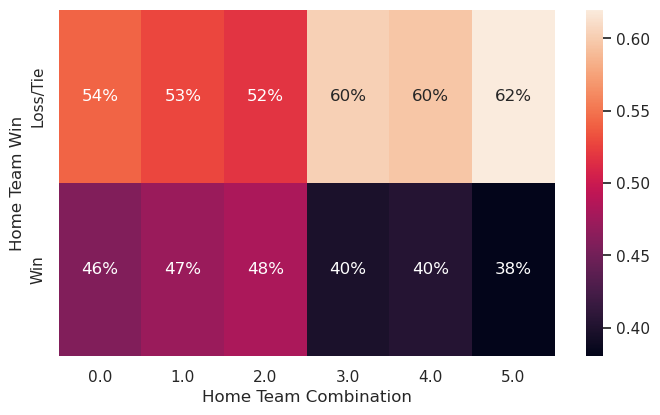

In [39]:
fig_combo_contingency, ax_combo_contingency = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
sns.heatmap(
    comb_h_home_w_con_tab.apply(lambda x: x.div(x.sum(), axis=0)),
    fmt=".0%",
    annot=True,
    ax=ax_combo_contingency,
)
disf.axis_titles(ax=ax_combo_contingency,xtitle="Home Team Combination", ytitle="Home Team Win")
ax_combo_contingency.set_yticklabels(['Loss/Tie','Win'])
plt.show()

#### Can the combinations be used to predict match outcome?

##### Random Forest ML model:

In [40]:
match_win_df_combo.dropna(inplace=True)
home_win_target = match_win_df_combo["home_team_win"]
home_win_team_features = match_win_df_combo[["combinations_home", "combinations_away"]]
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target, test_size=0.33, random_state=1
)

# Create and fit the logistic regression model
logit_model = RandomForestClassifier()
result = logit_model.fit(X_train,y_train)

# Predict using the trained model
predictions = result.predict(X_test)

# Print the predicted probabilities
print(classification_report(y_test, predictions.round()))

              precision    recall  f1-score   support

           0       0.55      0.81      0.66      4360
           1       0.47      0.20      0.29      3607

    accuracy                           0.54      7967
   macro avg       0.51      0.51      0.47      7967
weighted avg       0.52      0.54      0.49      7967



##### Outcome skew in the test set:

In [41]:
y_test.value_counts(normalize=True).to_frame(name='Fraction')

,Fraction
0,0.547257
1,0.452743


The random forest model based on the home team and away team starting line-up combinations predicted the game outcome with 54% accuracy. This value does not be the underlying outcome data skew, therefore these features are dismissed in the final model.

### Team Attributes

##### Importing team attributes into a dataframe:

In [42]:
team_attr_raw = con.query(
    """--sql
SELECT *
FROM Team_attributes
"""
).to_df()

team_attr_raw["date"] = pd.to_datetime(team_attr_raw["date"])
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(pd.to_numeric)

##### Creating Team class objects for each team:

In [43]:
unique_team_ids = [
    i[0]
    for i in con.query(
        """--sql
SELECT DISTINCT team_api_id
FROM Team_attributes
"""
    ).fetchall()
]
teams={}

for team in unique_team_ids:
    teams[team]=Team(team)
    teams[team].get_data(team_attr_raw)

##### Removing matches with teams that have no attributes:

In [45]:
match_win_df_team = match_win_df[
    match_win_df.index.isin(match_win_df_combo.index)
]  # not using rows with missing combination data
match_win_df_team = match_win_df[
    ~match_win_df["away_team_api_id"].isin(
        set(unique_team_ids).symmetric_difference(
            match_win_df["away_team_api_id"].unique()
        )
    )
]

match_win_df_team = match_win_df_team[
    ~match_win_df_team["home_team_api_id"].isin(
        set(unique_team_ids).symmetric_difference(
            match_win_df_team["home_team_api_id"].unique()
        )
    )
]

##### Getting the latest team attributes by match date using the Team class:

In [46]:
team_attributes_home = {}
for index in match_win_df_team.index:
    team_attributes_home[index] = teams[
        match_win_df_team.at[index, "home_team_api_id"]
    ].get_latest_entry(match_win_df_team.loc[index, "date"], team_numeric_cols)

team_attributes_away = {}
for index in match_win_df_team.index:
    team_attributes_away[index] = teams[
        match_win_df_team.at[index, "away_team_api_id"]
    ].get_latest_entry(match_win_df_team.loc[index, "date"], team_numeric_cols)

match_win_df_team = match_win_df_team.join(
    pd.concat(
        list(team_attributes_home.values()), keys=team_attributes_home.keys()
    ).droplevel(1),
    rsuffix="_home",
)

match_win_df_team = match_win_df_team.join(
    pd.concat(
        list(team_attributes_away.values()), keys=team_attributes_away.keys()
    ).droplevel(1),
    rsuffix="_away",
)

##### Dropping matches where teams do not have date relevant attributes:

In [47]:
match_win_df_team.dropna(inplace=True)

#### Logistic regression with all home and away team attributes

##### Model training and prediction:

In [48]:
cols_to_drop = [
    "date",
    "country_id",
    "home_team_api_id",
    "away_team_api_id",
    "home_team_goal",
    "away_team_goal",
    "home_team_win",
]

home_win_target_team = match_win_df_team["home_team_win"]
home_win_team_features = match_win_df_team.drop(columns=cols_to_drop)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target_team, test_size=0.33, random_state=1
)

# Scaling the data
team_feat_scaler = StandardScaler()
X_train = team_feat_scaler.fit_transform(X_train)
X_test = team_feat_scaler.fit_transform(X_test)


# Create and fit the logistic regression model
logit_model_team_raw = sm.Logit(y_train, sm.add_constant(X_train))
result_team_raw = logit_model_team_raw.fit()

# Predict using the trained model
predictions_team_raw = result_team_raw.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_team_raw.round()))

Optimization terminated successfully.
         Current function value: 0.670147
         Iterations 4
              precision    recall  f1-score   support

           0       0.59      0.78      0.67      1010
           1       0.55      0.33      0.41       826

    accuracy                           0.58      1836
   macro avg       0.57      0.56      0.54      1836
weighted avg       0.57      0.58      0.56      1836



##### Test set outcome skew:

In [49]:
y_test.value_counts(normalize=True).to_frame(name='Fraction')

,Fraction
0,0.550109
1,0.449891


##### Model coefficients:

In [50]:
pd.DataFrame(
    result_team_raw.params[1:].values,
    index=match_win_df_team.drop(columns=cols_to_drop).columns,
).sort_values(0)

,0
buildUpPlayPassing,-0.119939
defenceAggression_away,-0.117195
buildUpPlaySpeed,-0.075989
defenceTeamWidth,-0.074180
chanceCreationCrossing_away,-0.068292
defencePressure_away,-0.067938
chanceCreationShooting_away,-0.044613
defenceTeamWidth_away,-0.032423
buildUpPlayDribbling_away,-0.010299
buildUpPlayDribbling,-0.009318


The logistic regression model using 18 team features was able to predict the game outcome with a 58% accuracy, that only slightly beats the natural skew of the dataset. Further, in order to reduce the number of features the differences of these team attributes between home and away teams will be used.

#### Logistic regression with home-away team attribute differences

##### Training the model and predictions:

In [51]:
home_win_team_features_dif = match_win_df_team.drop(columns=cols_to_drop)
home_win_team_features_dif = (
    home_win_team_features_dif[team_numeric_cols].values
    - home_win_team_features_dif[[col + "_away" for col in team_numeric_cols]].values
)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features_dif, home_win_target_team, test_size=0.33, random_state=1
)

# Scale the data
team_feat_ratio_scaler = StandardScaler()
X_train = team_feat_ratio_scaler.fit_transform(X_train)
X_test = team_feat_ratio_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()

# Predict using the trained model
predictions = result.predict(sm.add_constant(X_test))

# Print the classification report
print(classification_report(y_test, predictions.round()))

Optimization terminated successfully.
         Current function value: 0.672126
         Iterations 4
              precision    recall  f1-score   support

           0       0.59      0.79      0.68      1010
           1       0.56      0.32      0.41       826

    accuracy                           0.58      1836
   macro avg       0.57      0.56      0.54      1836
weighted avg       0.57      0.58      0.55      1836



##### Model coefficients

In [52]:
pd.DataFrame(
    result.params[1:].values,
    index=team_numeric_cols,
).sort_values(0)

,0
buildUpPlayPassing,-0.155055
buildUpPlaySpeed,-0.052334
defenceTeamWidth,-0.027599
buildUpPlayDribbling,0.003255
chanceCreationPassing,0.011143
chanceCreationShooting,0.068049
defencePressure,0.149047
defenceAggression,0.152408
chanceCreationCrossing,0.153614


#### Dimensionality reduction with principal component analysis

In order to reduce the number of team attributes required for match outcome prediction principal component analysis will be implemented.

##### Scree plot:

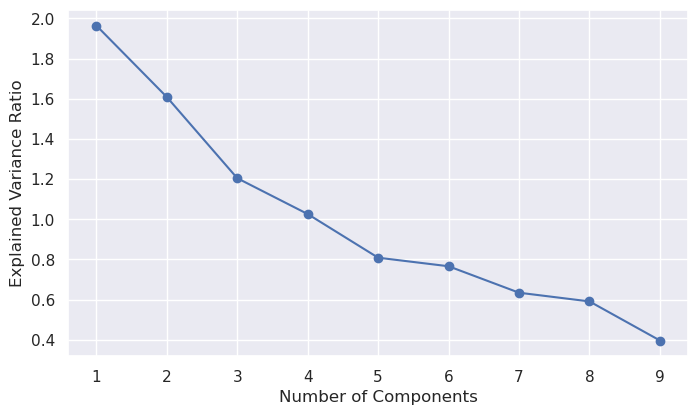

In [53]:
# Perform PCA with maximum number of components
pca_team = PCA(n_components=9)
pca_team.fit(X_train)

fig_scree,ax_scree=plt.subplots(figsize=(base_fig_width,base_fig_height)) 

ax_scree.plot(np.arange(pca_team.n_components_)+1, pca_team.explained_variance_, marker='o')
ax_scree.set_xlabel('Number of Components')
ax_scree.set_ylabel('Explained Variance Ratio')
plt.show()

There seems to be a leveling off of the variance lost after 5 principal components, therefore for further analysis five principal components will be used.

##### Logistic regression using 5 team attribute principle components:

In [54]:
pca = PCA(n_components=5)
X_team_pca_train = pca.fit_transform(X_train)
X_team_pca_test = pca.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_team_diff_pc = sm.Logit(y_train, sm.add_constant(X_team_pca_train))
result_team_diff_pc = logit_model_team_diff_pc.fit()

# Predict using the trained model
predictions_team_diff_pc = result_team_diff_pc.predict(sm.add_constant(X_team_pca_test))

# Print the classification report
print(classification_report(y_test, predictions_team_diff_pc.round()))



Optimization terminated successfully.
         Current function value: 0.674551
         Iterations 4
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      1010
           1       0.47      0.22      0.30       826

    accuracy                           0.54      1836
   macro avg       0.51      0.51      0.48      1836
weighted avg       0.51      0.54      0.49      1836



Reducing the number of features into five principal components has reduced the accuracy of the model to 54%. This is less than the skew of the test set, therefore even using a relatively large number of principal components has diminished the prediction capabilities to where the model has zero value. Due to this reason PCA will not be used in further analysis, and all 9 attribute differences will be used in the final model.

### Player Attributes

Getting the date relevant attributes of each match player using the MatchPlayer class Player subclass and their functions:

In [ ]:
# # only using rows with team attributes
# match_win_df_player = match_win_df.copy()[
#     match_win_df.index.isin(match_win_df_team.index)
# ]

# # Creating MatchPlayers objects for each match
# match_players_series = {}
# for i in match_win_df_player.index:
#     match_players_series[i] = MatchPlayers()
# match_players_series = pd.Series(match_players_series, name="match_players")
# match_win_df_player = match_win_df_player.join(match_players_series)

# # Using the MatchPlayers methods and the player subclass and it's methods to store date
# # player attribute data for each match
# for index, row in match_raw[match_raw.index.isin(match_win_df_player.index)].iterrows():
#     match_win_df_player.at[index, "match_players"].get_data(row)
#     match_win_df_player.at[index, "match_players"].get_player_positions()
#     match_win_df_player.at[index, "match_players"].get_player_ids()
#     match_win_df_player.at[index, "match_players"].home_players[
#         "goaly"
#     ].get_player_attributes(player_attr_raw, row["date"])
#     match_win_df_player.at[index, "match_players"].away_players[
#         "goaly"
#     ].get_player_attributes(player_attr_raw, row["date"])
#     for player in match_win_df_player.at[index, "match_players"].home_players[
#         "players"
#     ]:
#         player.get_player_attributes(player_attr_raw, row["date"])
#     for player in match_win_df_player.at[index, "match_players"].away_players[
#         "players"
#     ]:
#         player.get_player_attributes(player_attr_raw, row["date"])

In [56]:
import pickle 
# with open('match_win_df_player.pkl', 'wb') as file:
#     pickle.dump(match_win_df_player, file)

with open('match_win_df_player.pkl', 'rb') as file:
    match_win_df_player = pickle.load(file)


#### Logistic regression using all attributes

##### Exporting all player attributes:

In [57]:
#Export all player attributes for each mach in to a dictionary
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[i, "match_players"].export_player_attributes(
        player_attr_numeric, how="all"
    )

#Merging with the match dataframe
match_win_players = pd.DataFrame.from_dict(player_att_dict, orient="index").join(
    match_win_df["home_team_win"]
)

# Dropping rows with missing values
match_win_players.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
match_win_players = match_win_players[
    match_win_players.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

##### Logistic Regression with all player attributes:

In [93]:
home_win_target_player = match_win_players["home_team_win"]
home_win_features_player = match_win_players.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_player, home_win_target_player, test_size=0.33, random_state=1
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_player_all = sm.Logit(y_train, sm.add_constant(X_train))
result_player_all = logit_model_player_all.fit_regularized(method='l1_cvxopt_cp',alpha=0.2,disp=0)

# Predict using the trained model
predictions_player_all = result_player_all.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_player_all.round()))


              precision    recall  f1-score   support

           0       0.63      0.62      0.62       933
           1       0.52      0.53      0.53       736

    accuracy                           0.58      1669
   macro avg       0.57      0.57      0.57      1669
weighted avg       0.58      0.58      0.58      1669



##### What is the test data set skew?

In [96]:
y_test.value_counts(normalize=True).to_frame('Fraction')

,Fraction
0,0.559017
1,0.440983


##### Coefficients and their p-values:

In [97]:
# Displaying the coefficients and their p-values
params_player_all=result_player_all.params[1:].to_frame(name='Coefficient')
params_player_all['p-value']=result_player_all.pvalues[1:].values
params_player_all.index=home_win_features_player.columns
display(Markdown('Largest positive coefficients:'))
display(params_player_all.sort_values('Coefficient',ascending=False).head())
display(Markdown('Largest negative coefficients:'))
display(params_player_all.sort_values('Coefficient',ascending=False).tail())

Largest positive coefficients:

,Coefficient,p-value
overall_rating_A_6,0.492667,0.007626
marking_A_2,0.447044,0.004872
overall_rating_H_2,0.412170,0.183666
ball_control_A_10,0.379404,0.014108
sliding_tackle_H_gk,0.315451,0.068476


Largest negative coefficients:

,Coefficient,p-value
overall_rating_H_9,-0.452559,0.054490
sliding_tackle_H_5,-0.493653,0.007058
overall_rating_H_10,-0.512273,0.050265
overall_rating_A_2,-0.567206,0.238090
overall_rating_A_gk,-0.889842,0.303472


The model using all player attributes was able to predict the game outcome with a 58% accuracy. This only slightly beats the data skew, yet uses 770 different features. Due to such large number of features in relevance to the number of samples even using lasso regression to penalize large coefficients, some of the coefficients that are largest in magnitudes have p-values above significance level. Therefore to improve the models predictive power and simplicity attempts to reduce the number of features are required.

#### Logistic regression using the differences of player attributes:

The simplest approach to feature reduction is implemented here by utilizing the differences in attributes between home and away players instead of using attributes from all players. This method effectively reduces the number of features by half. Furthermore, as it is difficult to distinguish between non goalkeeper players instead of separate attribute differences, the average of all non-goalkeeper players is used, this further decreases the number of features several times to the final number of 70 from the original 770.

##### Fetching relevant differences of player attributes:

In [100]:
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[i, "match_players"].export_player_attributes(
        player_attr_numeric, how="avg_diff"
    )

match_win_df_player = pd.DataFrame.from_dict(player_att_dict, orient="index").join(
    match_win_df["home_team_win"]
)

# Dropping rows with missing values
match_win_df_player.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
match_win_df_player = match_win_df_player[
    match_win_df_player.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

##### Logistic regression using player attribute differences

In [106]:
home_win_target_playerdif = match_win_players["home_team_win"]
home_win_features_playerdif = match_win_df_player.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif, home_win_target_playerdif, test_size=0.33, random_state=1
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_player_dif = sm.Logit(y_train, sm.add_constant(X_train))
result_player_dif = logit_model_player_dif.fit_regularized(method='l1_cvxopt_cp',alpha=0.1,disp=0)

# Predict using the trained model
predictions_player_dif = result_player_dif.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_player_dif.round()))


              precision    recall  f1-score   support

           0       0.67      0.75      0.71       933
           1       0.62      0.53      0.58       736

    accuracy                           0.65      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.65      0.65      0.65      1669



##### The most important coefficients and their p-values

In [109]:
# Displaying the coefficients and their p-values
params_player_dif=result_player_dif.params[1:].to_frame(name='Coefficient')
params_player_dif['p-value']=result_player_dif.pvalues[1:].values
params_player_dif.index=home_win_features_playerdif.columns
display(Markdown('Largest positive coefficients:'))
display(params_player_dif.sort_values('Coefficient',ascending=False).head())

Largest positive coefficients:

,Coefficient,p-value
overall_rating_avg_diff_gk,0.656434,0.150866
overall_rating_avg_diff,0.350027,0.046064
vision_avg_diff,0.239988,0.015042
acceleration_avg_diff,0.205494,0.049714
standing_tackle_avg_diff,0.184660,0.082748


Reducing the number of features by calculating the average differences of player attributes has increased the prediction accuracy of the model to 65%. Yet not all of the largest coefficients are significant, which suggest a high uncertainty in their determination and room for model improvement.

RFE

In [111]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

home_win_target = match_win_df_player["home_team_win"]
home_win_player_features = match_win_df_player.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_player_features, home_win_target, test_size=0.33, random_state=1
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logreg_model = LogisticRegression()

# Create RFE object and perform feature selection
rfe = RFECV(estimator=logreg_model, cv=5)  # Adjust the number of cross-validation folds as needed
rfe.fit(X_train, y_train)

# Select the top features based on RFE
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Refit the logistic regression model with selected features
logreg_model_rfe = LogisticRegression()
logreg_model_rfe.fit(X_train_rfe, y_train)

selected_features = home_win_player_features.columns[rfe.support_]
print("Selected Features:", selected_features)

# Predict using the trained model with selected features
predictions_rfe = logreg_model_rfe.predict(X_test_rfe)

# Print the predicted probabilities
print(classification_report(y_test, predictions_rfe.round()))

Selected Features: Index(['overall_rating_avg_diff', 'vision_avg_diff',
       'standing_tackle_avg_diff', 'sliding_tackle_avg_diff'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       933
           1       0.64      0.52      0.57       736

    accuracy                           0.66      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.66      0.66      0.65      1669



In [113]:
pd.DataFrame(logreg_model_rfe.coef_.transpose(),selected_features,columns=['Coefficient'])

,Coefficient
overall_rating_avg_diff,0.617374
vision_avg_diff,0.194883
standing_tackle_avg_diff,0.150834
sliding_tackle_avg_diff,-0.196065


Single Feature

In [ ]:
home_win_target = match_win_players["home_team_win"]
home_win_player_features = match_win_players['overall_rating_avg_diff']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_player_features, home_win_target, test_size=0.33, random_state=1
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train.values.reshape(-1, 1))
X_test = player_feat_scaler.fit_transform(X_test.values.reshape(-1, 1))

# Fit the logistic regression model
logreg_overal_rating = LogisticRegression()
logreg_overal_rating.fit(X_train, y_train)

# Predict using the trained model with selected features
predictions_overal_rating = logreg_overal_rating.predict(X_test)

# Print the predicted probabilities
print(classification_report(y_test, predictions_overal_rating.round()))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71       933
           1       0.63      0.51      0.56       736

    accuracy                           0.65      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.65      0.65      0.65      1669



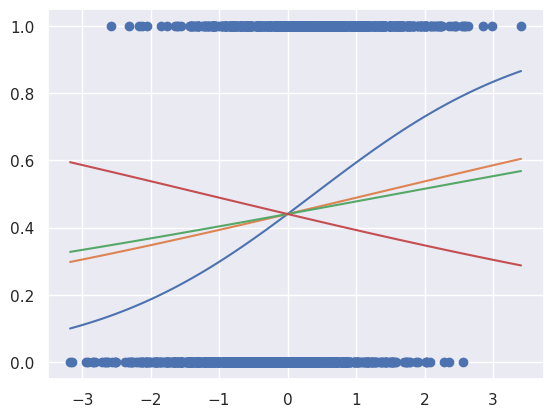

In [ ]:

x_values = np.linspace(min(X_test), max(X_test), 100)

# Calculate corresponding y-values using logistic function
y_values = 1 / (1 + np.exp(-(logreg_model_rfe.coef_ * x_values + logreg_model_rfe.intercept_)))

# Plot scatter plot
plt.scatter(X_test, y_test)

# Plot the fitted line
plt.plot(x_values, y_values)

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Team_Attributes LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   team_fifa_api_id |   team_api_id | date                |   buildUpPlaySpeed | buildUpPlaySpeedClass   |   buildUpPlayDribbling | buildUpPlayDribblingClass   |   buildUpPlayPassing | buildUpPlayPassingClass   | buildUpPlayPositioningClass   |   chanceCreationPassing | chanceCreationPassingClass   |   chanceCreationCrossing | chanceCreationCrossingClass   |   chanceCreationShooting | chanceCreationShootingClass   | chanceCreationPositioningClass   |   defencePressure | defencePressureClass   |   defenceAggression | defenceAggressionClass   |   defenceTeamWidth | defenceTeamWidthClass   | defenceDefenderLineClass   |
|-----:|-------------------:|--------------:|:--------------------|-------------------:|:------------------------|-----------------------:|:----------------------------|---------------------:|:--------------------------|:------------------------------|------------------------:|:-----------------------------|-------------------------:|:------------------------------|-------------------------:|:------------------------------|:---------------------------------|------------------:|:-----------------------|--------------------:|:-------------------------|-------------------:|:------------------------|:---------------------------|
|    1 |                434 |          9930 | 2010-02-22 00:00:00 |                 60 | Balanced                |                    nan | Little                      |                   50 | Mixed                     | Organised                     |                      60 | Normal                       |                       65 | Normal                        |                       55 | Normal                        | Organised                        |                50 | Medium                 |                  55 | Press                    |                 45 | Normal                  | Cover                      |
|    2 |                434 |          9930 | 2014-09-19 00:00:00 |                 52 | Balanced                |                     48 | Normal                      |                   56 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    3 |                434 |          9930 | 2015-09-10 00:00:00 |                 47 | Balanced                |                     41 | Normal                      |                   54 | Mixed                     | Organised                     |                      54 | Normal                       |                       63 | Normal                        |                       64 | Normal                        | Organised                        |                47 | Medium                 |                  44 | Press                    |                 54 | Normal                  | Cover                      |
|    4 |                 77 |          8485 | 2010-02-22 00:00:00 |                 70 | Fast                    |                    nan | Little                      |                   70 | Long                      | Organised                     |                      70 | Risky                        |                       70 | Lots                          |                       70 | Lots                          | Organised                        |                60 | Medium                 |                  70 | Double                   |                 70 | Wide                    | Cover                      |
|    5 |                 77 |          8485 | 2011-02-22 00:00:00 |                 47 | Balanced                |                    nan | Little                      |                   52 | Mixed                     | Organised                     |                      53 | Normal                       |                       48 | Normal                        |                       52 | Normal                        | Organised                        |                47 | Medium                 |                  47 | Press                    |                 52 | Normal                  | Cover                      |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from Match LIMIT 5"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   id |   country_id |   league_id | season    |   stage | date                |   match_api_id |   home_team_api_id |   away_team_api_id |   home_team_goal |   away_team_goal |   home_player_X1 |   home_player_X2 |   home_player_X3 |   home_player_X4 |   home_player_X5 |   home_player_X6 |   home_player_X7 |   home_player_X8 |   home_player_X9 |   home_player_X10 |   home_player_X11 |   away_player_X1 |   away_player_X2 |   away_player_X3 |   away_player_X4 |   away_player_X5 |   away_player_X6 |   away_player_X7 |   away_player_X8 |   away_player_X9 |   away_player_X10 |   away_player_X11 |   home_player_Y1 |   home_player_Y2 |   home_player_Y3 |   home_player_Y4 |   home_player_Y5 |   home_player_Y6 |   home_player_Y7 |   home_player_Y8 |   home_player_Y9 |   home_player_Y10 |   home_player_Y11 |   away_player_Y1 |   away_player_Y2 |   away_player_Y3 |   away_player_Y4 |   away_player_Y5 |   away_player_Y6 |   away_player_Y7 |   away_player_Y8 |   away_player_Y9 |   away_player_Y10 |   away_player_Y11 |   home_player_1 |   home_player_2 |   home_player_3 |   home_player_4 |   home_player_5 |   home_player_6 |   home_player_7 |   home_player_8 |   home_player_9 |   home_player_10 |   home_player_11 |   away_player_1 |   away_player_2 |   away_player_3 |   away_player_4 |   away_player_5 |   away_player_6 |   away_player_7 |   away_player_8 |   away_player_9 |   away_player_10 |   away_player_11 |   goal |   shoton |   shotoff |   foulcommit |   card |   cross |   corner |   possession |   B365H |   B365D |   B365A |   BWH |   BWD |   BWA |   IWH |   IWD |   IWA |   LBH |   LBD |   LBA |   PSH |   PSD |   PSA |   WHH |   WHD |   WHA |   SJH |   SJD |   SJA |   VCH |   VCD |   VCA |   GBH |   GBD |   GBA |   BSH |   BSD |   BSA |
|-----:|-------------:|------------:|:----------|--------:|:--------------------|---------------:|-------------------:|-------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|----------------:|-----------------:|-----------------:|-------:|---------:|----------:|-------------:|-------:|--------:|---------:|-------------:|--------:|--------:|--------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
|    1 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492473 |               9987 |               9993 |                1 |                1 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.73 |    3.4  |    5    |  1.75 |  3.35 |  4.2  |  1.85 |   3.2 |   3.5 |  1.8  |   3.3 |  3.75 |   nan |   nan |   nan |  1.7  |  3.3  |  4.33 |  1.9  |   3.3 |  4    |  1.65 |  3.4  |  4.5  |  1.78 |  3.25 |  4    |  1.73 |  3.4  |  4.2  |
|    2 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492474 |              10000 |               9994 |                0 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.95 |    3.2  |    3.6  |  1.8  |  3.3  |  3.95 |  1.9  |   3.2 |   3.5 |  1.9  |   3.2 |  3.5  |   nan |   nan |   nan |  1.83 |  3.3  |  3.6  |  1.95 |   3.3 |  3.8  |  2    |  3.25 |  3.25 |  1.85 |  3.25 |  3.75 |  1.91 |  3.25 |  3.6  |
|    3 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492475 |               9984 |               8635 |                0 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    2.38 |    3.3  |    2.75 |  2.4  |  3.3  |  2.55 |  2.6  |   3.1 |   2.3 |  2.5  |   3.2 |  2.5  |   nan |   nan |   nan |  2.5  |  3.25 |  2.4  |  2.63 |   3.3 |  2.5  |  2.35 |  3.25 |  2.65 |  2.5  |  3.2  |  2.5  |  2.3  |  3.2  |  2.75 |
|    4 |            1 |           1 | 2008/2009 |       1 | 2008-08-17 00:00:00 |         492476 |               9991 |               9998 |                5 |                0 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    1.44 |    3.75 |    7.5  |  1.4  |  4    |  6.8  |  1.4  |   3.9 |   6   |  1.44 |   3.6 |  6.5  |   nan |   nan |   nan |  1.44 |  3.75 |  6    |  1.44 |   4   |  7.5  |  1.45 |  3.75 |  6.5  |  1.5  |  3.75 |  5.5  |  1.44 |  3.75 |  6.5  |
|    5 |            1 |           1 | 2008/2009 |       1 | 2008-08-16 00:00:00 |         492477 |               7947 |               9985 |                1 |                3 |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |              nan |               nan |               nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |             nan |              nan |              nan |    nan |      nan |       nan |          nan |    nan |     nan |      nan |          nan |    5    |    3.5  |    1.65 |  5    |  3.5  |  1.6  |  4    |   3.3 |   1.7 |  4    |   3.4 |  1.72 |   nan |   nan |   nan |  4.2  |  3.4  |  1.7  |  4.5  |   3.5 |  1.73 |  4.5  |  3.4  |  1.65 |  4.5  |  3.5  |  1.65 |  4.75 |  3.3  |  1.67 |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT * from League"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|    id |   country_id | name                     |
|------:|-------------:|:-------------------------|
|     1 |            1 | Belgium Jupiler League   |
|  1729 |         1729 | England Premier League   |
|  4769 |         4769 | France Ligue 1           |
|  7809 |         7809 | Germany 1. Bundesliga    |
| 10257 |        10257 | Italy Serie A            |
| 13274 |        13274 | Netherlands Eredivisie   |
| 15722 |        15722 | Poland Ekstraklasa       |
| 17642 |        17642 | Portugal Liga ZON Sagres |
| 19694 |        19694 | Scotland Premier League  |
| 21518 |        21518 | Spain LIGA BBVA          |
| 24558 |        24558 | Switzerland Super League |

In [ ]:
Markdown(tabulate(con.query(
    f"""--sql
SELECT league_id, count(id) from Match group by league_id"""
).to_df(), showindex=False, headers="keys", tablefmt="pipe"))

|   league_id |   count(id) |
|------------:|------------:|
|           1 |        1728 |
|        1729 |        3040 |
|        4769 |        3040 |
|        7809 |        2448 |
|       10257 |        3017 |
|       13274 |        2448 |
|       15722 |        1920 |
|       17642 |        2052 |
|       19694 |        1824 |
|       21518 |        3040 |
|       24558 |        1422 |